In [3]:
import gc
gc.collect()

476

In [11]:
%reset -f

RGB


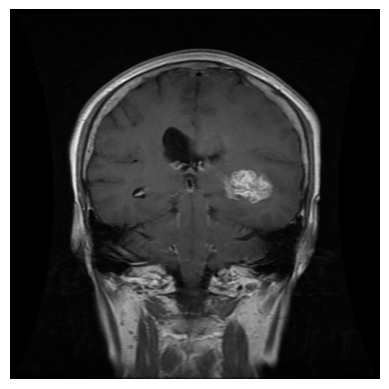

In [4]:
import os
import random
from PIL import Image

import matplotlib.pyplot as plt

# Set the directory path
directory = "../Data/brain_tumor_4variants/Testing/glioma_tumor"

# Get a list of all .jpg files in the directory
file_list = [file for file in os.listdir(directory) if file.endswith(".jpg")]

# Select a random image from the list
random_image = random.choice(file_list)

# Load and display the image
image_path = os.path.join(directory, random_image)
image = Image.open(image_path)
plt.imshow(image)
print(image.mode)
plt.axis("off")
plt.show()

In [5]:
import pandas as pd

# Set the directory paths
directories = ["../Data/brain_tumor_4variants/Training", "../Data/brain_tumor_4variants/Testing",
               "../Data/brain_tumor_4variants2/Training", "../Data/brain_tumor_4variants2/Testing"]

# Initialize empty lists to store the data
data_1 = []
data_2 = []

# Define the label mappings for the second dataset
label_mapping = {
    "no_tumor": 0,
    "notumor": 0,
    "glioma_tumor": 1,
    "glioma": 1,
    "meningioma_tumor": 2,
    "meningioma": 2,
    "pituitary_tumor": 3,
    "pituitary": 3
}

# Iterate through the directories
for directory in directories:
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            # Get a list of all .jpg files in the subdirectory
            file_list = [file for file in os.listdir(
                subdir_path) if file.endswith(".jpg")]

            # Append the data to data_1
            data_1.extend([(os.path.join(subdir_path, file), 0 if subdir in [
                          "no_tumor", "notumor"] else 1) for file in file_list])

            # Append the data to data_2
            data_2.extend([(os.path.join(subdir_path, file),
                          label_mapping[subdir]) for file in file_list])

# Create the datasets as pandas DataFrames
dataset_1 = pd.DataFrame(
    data_1, columns=["Image_Path", "Dependent_Variable_01"])
dataset_2 = pd.DataFrame(
    data_2, columns=["Image_Path", "Dependent_Variable_0123"])

# Display the first few rows of each dataset
print(dataset_1.head())
print(dataset_2.head())

                                          Image_Path  Dependent_Variable_01
0  ../Data/brain_tumor_4variants/Training/no_tumo...                      0
1  ../Data/brain_tumor_4variants/Training/no_tumo...                      0
2  ../Data/brain_tumor_4variants/Training/no_tumo...                      0
3  ../Data/brain_tumor_4variants/Training/no_tumo...                      0
4  ../Data/brain_tumor_4variants/Training/no_tumo...                      0
                                          Image_Path  Dependent_Variable_0123
0  ../Data/brain_tumor_4variants/Training/no_tumo...                        0
1  ../Data/brain_tumor_4variants/Training/no_tumo...                        0
2  ../Data/brain_tumor_4variants/Training/no_tumo...                        0
3  ../Data/brain_tumor_4variants/Training/no_tumo...                        0
4  ../Data/brain_tumor_4variants/Training/no_tumo...                        0


In [ ]:
import torch

# Create an empty list to store the images
images = []

# Iterate through the dataset and collect the images
for image in dataset_1:
    images.append(image)

# Concatenate the images along the batch dimension
images = torch.stack(images)

# Calculate the mean and std of the images
mean = torch.mean(images, dim=(0, 2, 3))
std = torch.std(images, dim=(0, 2, 3))

# Print the mean and std
print("Mean:", mean)
print("Std:", std)

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# Define the custom dataset class


class BrainTumorDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        """
        Args:
            data_frame (pd.DataFrame): DataFrame with image paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = data_frame
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the item to fetch.
        
        Returns:
            tuple: (image, label) where image is the transformed image and label is the corresponding label.
        """
        img_path = self.data_frame.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        label = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # Normalize with ImageNet mean and std
    transforms.Normalize(
        mean=[-1.3006, -1.2001, -0.9724], std=[0.8727, 0.8922, 0.8884])
])

# Create the datasets using the DataFrames created earlier
btd1 = BrainTumorDataset(data_frame=dataset_1, transform=transform)
btd2 = BrainTumorDataset(data_frame=dataset_2, transform=transform)

In [ ]:
import json
import torchvision.models as models
import safetensors.torch

# Step 1: Load the configuration
with open('../Models/resnet18/config.json', 'r') as f:
    config = json.load(f)

# Step 2: Load the weights
weights = safetensors.torch.load_file('../Models/resnet18/model.safetensors')

# Step 3: Initialize the model
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 4)

# Step 4: Load the weights into the model
model.load_state_dict(weights, strict=False)

# Verify the model
print(model)

In [19]:
output_categories = len(set(btd2.targets))

AttributeError: 'BrainTumorDataset' object has no attribute 'targets'

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
import matplotlib.pyplot as plt

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

# Define the model (using a pre-trained ResNet18 model as an example)
model = models.resnet18(weights='IMAGENET1K_V1')
# Adjust the output layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 4)

# Define the loss function and optimizer and learning rate
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7)

# Define dataset and dataloader
dataset = btd2

# Calculate sizes for training, validation, and testing sets
val_size = int(0.05 * len(dataset))
train_size = int(0.8 * (len(dataset) - val_size))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=True, num_workers=0)

# Assertion to check input dimensions

def check_input_compatibility(model, input_size=(3, 224, 224)):
    dummy_input = torch.randn(1, *input_size).to(device)
    try:
        model.to(device)
        model(dummy_input)
        print("Model is compatible with the input size.")
    except Exception as e:
        print(f"Model is not compatible with the input size: {e}")


def check_output_compatibility(model, train_dataset):
    try:
        # Move model to the appropriate device
        model.to(device)
        
        # Identify the number of different labels in the training dataset
        labels = [train_dataset[i][1] for i in range(len(train_dataset))]
        output_categories = len(set(labels))

        # Check if the model's output layer has the same number of neurons as the number of labels
        if model.fc.out_features == output_categories:
            print("Model output layer is compatible with the number of labels in the dataset.")

    except Exception as e:
        print(f"Model has fewer/more neurons at final layer: {e}")


check_input_compatibility(model)
check_output_compatibility(model, dataset)

# Training and testing loop
num_epochs = 10
train_losses = []
accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}")

    # Testing phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy}%")

# Plotting the performance
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses,
         marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, marker='o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

mps
Model is compatible with the input size.
Model has fewer/more neurons at final layer: 'BrainTumorDataset' object has no attribute 'targets'


KeyboardInterrupt: 

In [11]:
import numpy as np

def eval_perform(model, dataset):
    # Set the model to evaluation mode
    model.eval()

    # Pick a random image from the dataset
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]

    # Prepare the image for the model
    # Add batch dimension and move to device
    image = image.unsqueeze(0).to(device)

    # Run the model on the image
    with torch.no_grad():
        logits = model(image)

    # Calculate probabilities
    probabilities = torch.softmax(logits, dim=1)

    # Display the image
    image_np = image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    
    # Denormalize the image using the provided mean and std
    mean = np.array([-1.3006, -1.2001, -0.9724])
    std = np.array([0.8727, 0.8922, 0.8884])
    image_np = image_np * std + mean
    image_np = np.clip(image_np, 0, 1)
    
    plt.imshow(image_np)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

    return logits, probabilities, label

# Example usage:
# logits, probabilities = eval_perform(model, test_dataset, device)
# print("Logits:", logits)
# print("Probabilities:", probabilities)

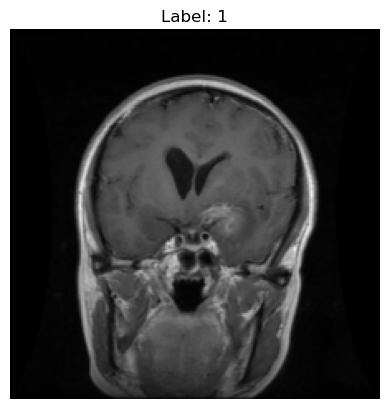

Probabilities: tensor([[0.0042, 0.1530, 0.8300, 0.0129]], device='mps:0')
Prediction: 2
Label: 1


In [52]:
logits, probabilities, label = eval_perform(model, test_dataset)
print("Probabilities:", probabilities)
_, prediction = torch.max(probabilities.data, 1)
print("Prediction:", int(prediction))
print("Label:", label)